This notebook demonstrates how to reconstruct the x position of hits using the output of GEMC using two different methods, and compares them to the truth level.  The first method uses the difference in time from the TDCs on either side, exploiting the fact that the signal-propagation time along a scintillator bar to the SiPMs at either end depends on the hit position.  The second uses the log of the ratio of the ADC values on either side, exploiting the attenuation of signal along the bar.  Finally we combine the results of the two recon methods.

In [161]:
import uproot
import numpy as np, pandas as pd
import scipy

import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

#presets for plot style
from scipy.constants import golden
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=18)
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rc('axes', labelsize=18)
rc('legend', fontsize=18)

import matplotlib.patches as patches

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

## First create the dataframe from the tree

In [163]:
f=uproot.open("out7438.root")
fcal=f["fcal"]
generated=f["generated"]

#fcal.keys()

In [164]:
flayer = fcal["layer"].array(library="pd")
fcomponent = fcal["component"].array(library="pd")
fADC_ord = fcal["ADC_order"].array(library="pd")
fADC_time = fcal["ADC_time"].array(library="pd")
fADC_ADC = fcal["ADC_ADC"].array(library="pd")
fTDC_ord = fcal["TDC_order"].array(library="pd")
fTDC_TDC = fcal["TDC_TDC"].array(library="pd")
ftotEdep = fcal["totEdep"].array(library="pd")
favgx = fcal["avg_x"].array(library="pd")
favgy = fcal["avg_y"].array(library="pd")
favgz = fcal["avg_z"].array(library="pd")
favgt = fcal["avg_t"].array(library="pd")

In [165]:
d = {a:[] for a in "avg_x avg_y avg_z avg_t TDCL TDCR ADCL ADCR ADCL_time ADCR_time layer component totEdep".split()}
for x,y,z,t,layer,component,ADC,ADCtime,ADCord,TDC,Edep in zip(favgx,favgy,favgz,favgt,flayer,fcomponent,fADC_ADC,fADC_time,fADC_ord,fTDC_TDC,ftotEdep):
    if ADCord == 0:
        d["avg_x"].append(x)
        d["avg_y"].append(y)
        d["avg_z"].append(z)
        d["avg_t"].append(t)
        d["layer"].append(layer)
        d["component"].append(component)
        d["TDCR"].append(TDC)
        d["ADCR"].append(ADC)
        d["ADCR_time"].append(ADCtime)
        d["totEdep"].append(Edep)
    elif ADCord == 1:
        d["TDCL"].append(TDC)
        d["ADCL"].append(ADC)
        d["ADCL_time"].append(ADCtime)


df = pd.DataFrame(d)

## First, determine where to set cut to filter out low-energy junk hits:

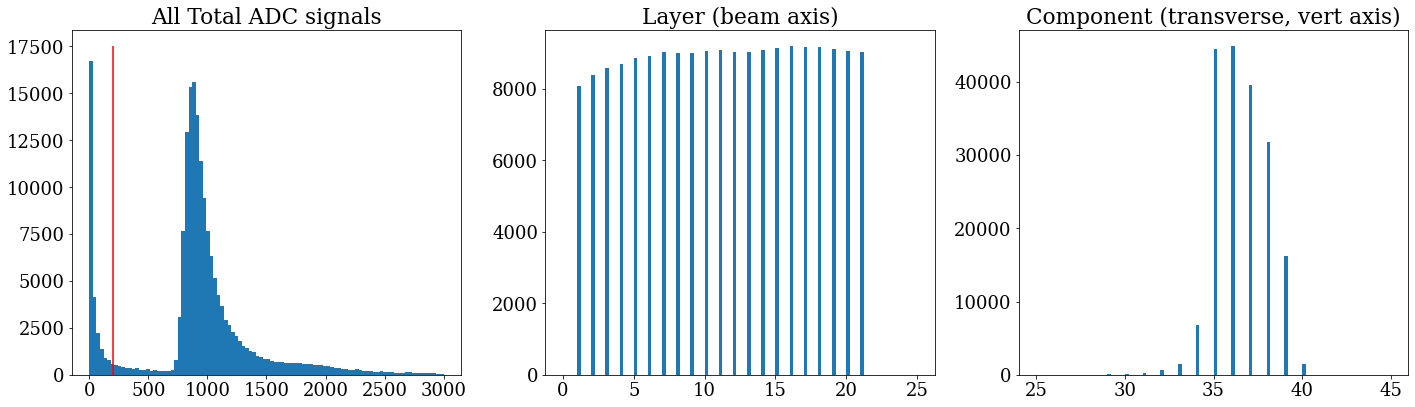

In [167]:
minGeoMean=200

#left = df.query("ADC_order==0")
#right = df.query("ADC_order==1")
#print(left)
#print(right)
#print(right["ADC_ADC"][0])
#LR=[]
#for i in range(len(left["ADC_ADC"])//2):
#    LR.append(left["ADC_ADC"][2*i]*right["ADC_ADC"][2*i+1])
#print(LR)

fig,ax = plt.subplots(1,3,figsize=(20,6))
ax[0].set_title("All Total ADC signals")
ax[0].hist(np.sqrt(df.ADCR*df.ADCL),bins=100,range=(0,3000))
ax[0].vlines(minGeoMean,ymin=0,ymax=17500, color='r')
ax[1].set_title("Layer (beam axis)")
ax[1].hist(df.layer,bins=100,range=(0,25))
ax[2].set_title("Component (transverse, vert axis)")
ax[2].hist(df.component,bins=100,range=(25,45))
plt.show()

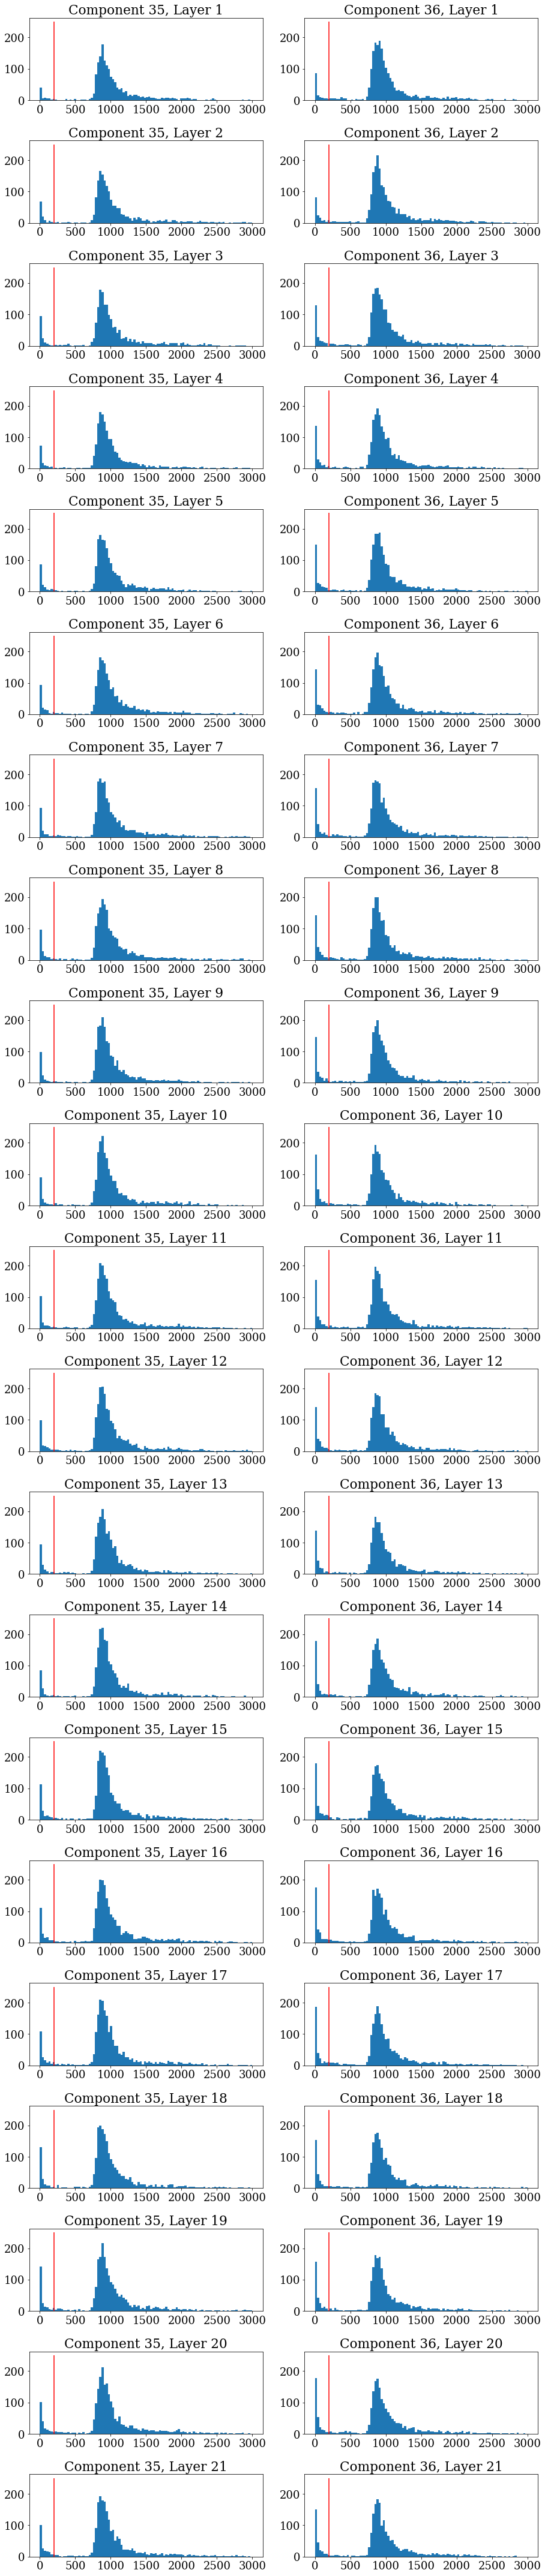

In [55]:
fig,ax = plt.subplots(21,2,figsize=(13,60))

for i in range(21):
    ax[i][0].set_title(f"Component 35, Layer {i+1}")
    ax[i][0].hist(np.sqrt(df.query(f"layer=={i+1} & component==35").ADCR*df.query(f"layer=={i+1} & component==35").ADCL),bins=100,range=(0,3000))
    ax[i][0].vlines(minGeoMean,ymin=0,ymax=250, color='r')
    ax[i][1].set_title(f"Component 36, Layer {i+1}")
    ax[i][1].hist(np.sqrt(df.query(f"layer=={i+1} & component==36").ADCR*df.query(f"layer=={i+1} & component==36").ADCL),bins=100,range=(0,3000))
    ax[i][1].vlines(minGeoMean,ymin=0,ymax=250, color='r')

plt.show()

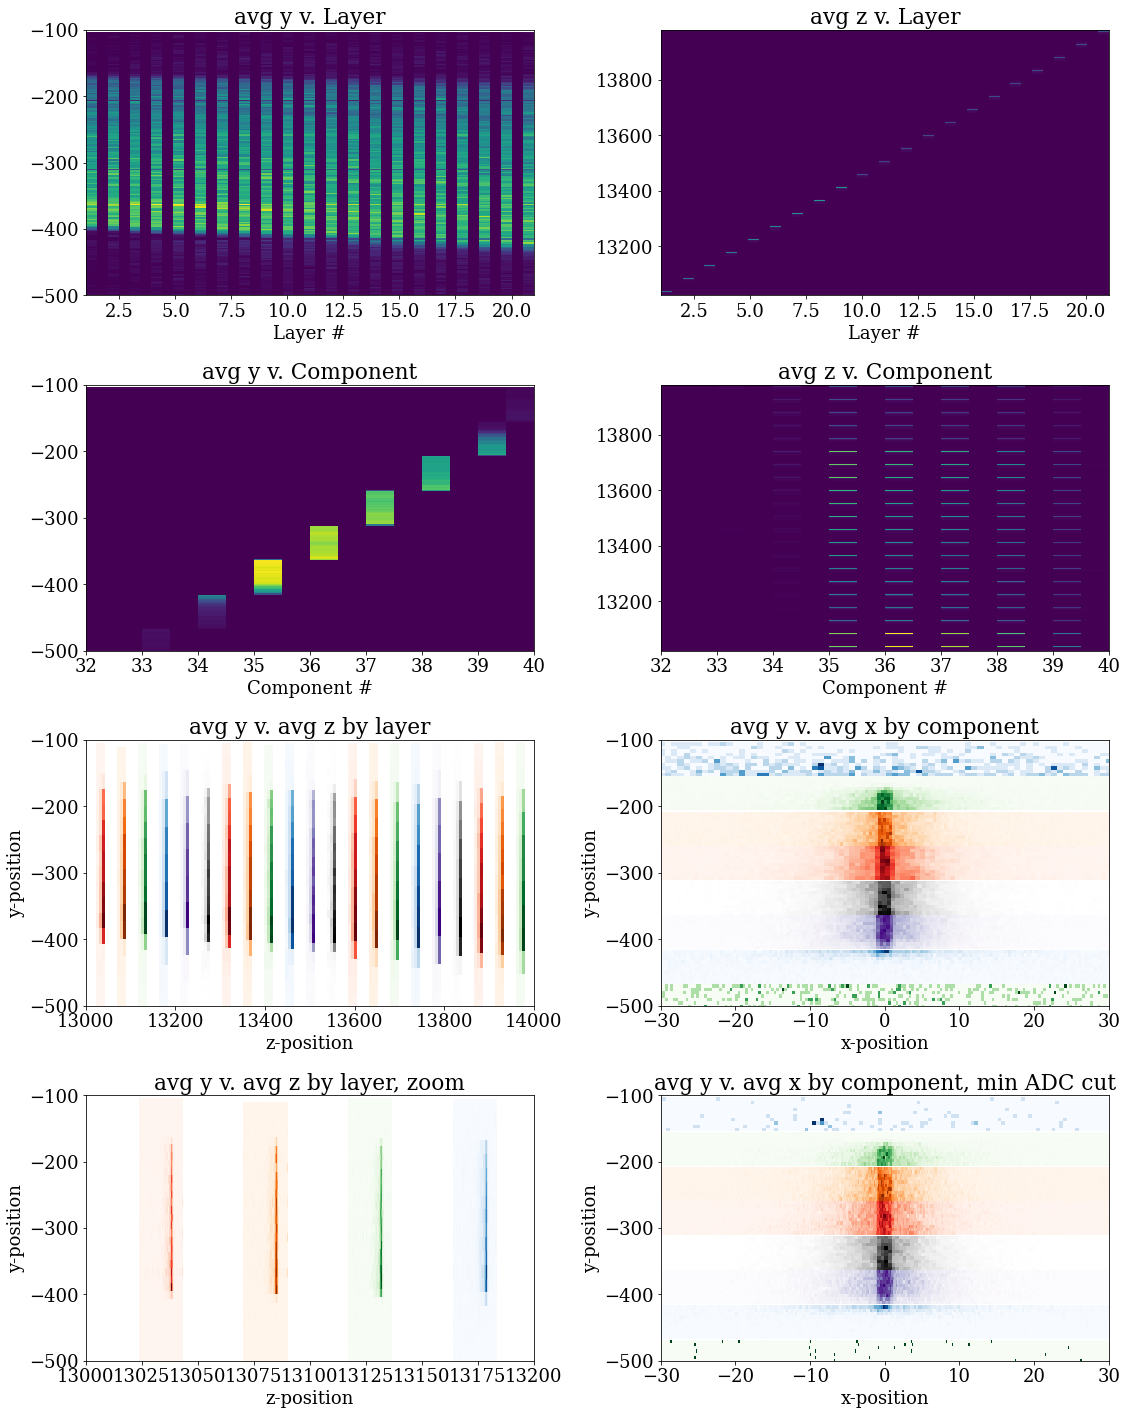

In [159]:
fig,ax = plt.subplots(4,2,figsize=(16,20))



ax[0][0].set_title(f"avg y v. Layer")
ax[0][0].hist2d(df.layer,df.avg_y, bins=(41, 1000))
ax[0][0].set_ylim(-500,-100)
ax[0][0].set_xlabel("Layer #")
ax[0][1].set_title(f"avg z v. Layer")
ax[0][1].set_xlabel("Layer #")
ax[0][1].hist2d(df.layer,df.avg_z, bins=(41, 1000))

ax[1][0].set_title(f"avg y v. Component")
ax[1][0].set_xlabel("Component #")
ax[1][0].hist2d(df.component,df.avg_y, bins=(78, 1000))
ax[1][0].set_ylim(-500,-100)
ax[1][0].set_xlim(32,40)
ax[1][1].set_xlabel("Component #")
ax[1][1].set_title(f"avg z v. Component")
ax[1][1].hist2d(df.component,df.avg_z, bins=(78, 1000))

ax[1][1].set_xlim(32,40)

cols=["Reds","Oranges","Greens","Blues","Purples","Greys"]
ax[2][0].set_title(f"avg y v. avg z by layer")
for i in range(21):
    ax[2][0].hist2d(df.query(f"layer=={i+1}").avg_z,df.query(f"layer=={i+1}").avg_y, bins=(3, 50),cmap=f"{cols[i%6]}")

ax[2][0].set_xlim(13000,14000)
ax[2][0].set_ylim(-500,-100)
ax[2][0].set_xlabel("z-position")
ax[2][0].set_ylabel("y-position")

ax[2][1].set_title(f"avg y v. avg x by component")
for i in range(40):
    ax[2][1].hist2d(df.query(f"component=={i+1}").avg_x,df.query(f"component=={i+1}").avg_y, bins=(3000, 10),cmap=f"{cols[i%6]}")
ax[2][1].set_xlim(-30,30)
ax[2][1].set_ylim(-500,-100)
ax[2][1].set_xlabel("x-position")
ax[2][1].set_ylabel("y-position")

cols=["Reds","Oranges","Greens","Blues","Purples","Greys"]
ax[3][0].set_title(f"avg y v. avg z by layer, zoom")
for i in range(21):
    ax[3][0].hist2d(df.query(f"layer=={i+1}").avg_z,df.query(f"layer=={i+1}").avg_y, bins=(80, 100),cmap=f"{cols[i%6]}")

ax[3][0].set_xlim(13000,13200)
ax[3][0].set_ylim(-500,-100)
ax[3][0].set_xlabel("z-position")
ax[3][0].set_ylabel("y-position")

ax[3][1].set_title(f"avg y v. avg x by component, min ADC cut")
for i in range(40):
    ax[3][1].hist2d(df.query(f"component=={i+1} & sqrt(ADCR*ADCL)>200").avg_x,df.query(f"component=={i+1} & sqrt(ADCR*ADCL)>200").avg_y, bins=(3000, 10),cmap=f"{cols[i%6]}")
ax[3][1].set_xlim(-30,30)
ax[3][1].set_ylim(-500,-100)
ax[3][1].set_xlabel("x-position")
ax[3][1].set_ylabel("y-position")

plt.show()

## Now determine the correlations between the hit x position and the TDCR-TDCL and also between x and the log(ADCL/ADCR)

The x position of the hits then can be reconstructed using either the TDC or the ADC.  

m,b= 0.5686716416454533 -0.008063104287606971


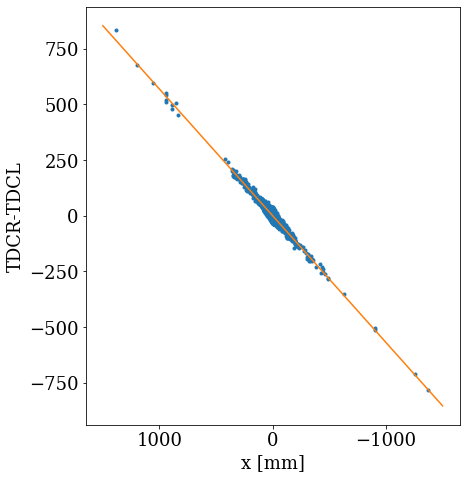

mu, sigma = -4.25378592102995e-16, 15.2291268410417


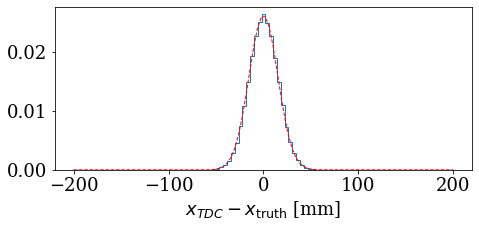

m,b= 0.0010034344934675195 0.0001668664164003141


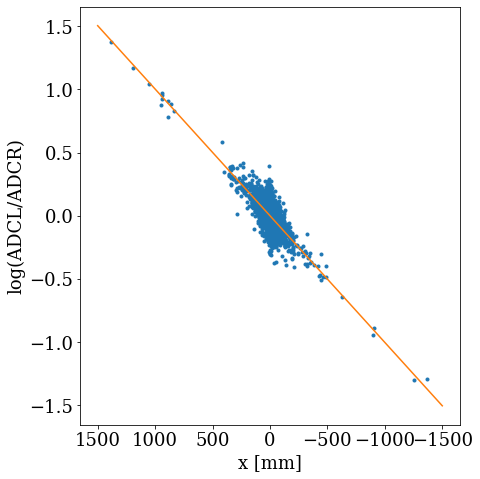

mu, sigma = -0.0009940625297521486, 46.46344159300223


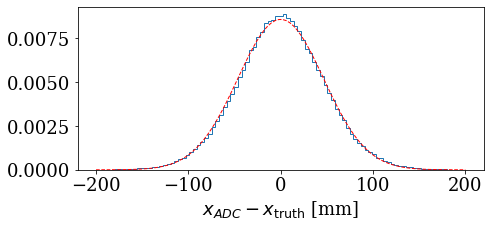

In [141]:
results =[]
for sigtype,label, formula in (("TDC","TDCR-TDCL","TDCR-TDCL"), 
                    ("ADC","log(ADCL/ADCR)","log(ADCL/ADCR)")):
    q="sqrt(ADCR*ADCL)>200"
    x=df.query(q).avg_x
    obs=df.query(q).eval(formula)
    m= (len(x)*np.sum(x*obs)-np.sum(x)*np.sum(obs))/(len(x)*np.sum(x*x)-np.sum(x)*np.sum(x))
    b = np.sum(obs-m*x)/len(x)
    print("m,b=", m, b)
    fig, axs = plt.subplots(1,1,figsize=(7,7))
    plt.plot(x[:], obs[:], marker='.', linestyle="")
    xpt = pd.Series([-1500, 1500])
    #plt.xlim(-.2,.2)
    plt.plot(xpt, m*xpt+b, linestyle="-")
    plt.gca().invert_xaxis()
    plt.xlabel("x [mm]")
    plt.ylabel(label)
    plt.show()
    
    #now create a residual plot
    from scipy.stats import norm
    import matplotlib.mlab as mlab
    residuals= x-(obs-b)/m
    (mu, sigma) = norm.fit(residuals[abs(residuals)<150])
    print(f"mu, sigma = {mu}, {sigma}")
    # the histogram of the data
    n, bins, patches = plt.hist(residuals, bins=np.linspace(-200, 200, 100), 
                            histtype='step',density=True)
    # add a 'best fit' line
    y = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(bins-mu)**2/(2*sigma**2))
    l = plt.plot(bins, y, 'r--', linewidth=1)

    plt.xlabel(f"$x_{{{sigtype}}}-x_{{\\rm truth}}$ [mm]")
    plt.show()
    results.append({"formula": formula, "m":m, "b":b, "sigma":sigma, "mu":mu})

## now combine both types of x reconstruction methods

{'formula': 'TDCR-TDCL', 'm': 0.5686716416454533, 'b': -0.008063104287606971, 'sigma': 15.2291268410417, 'mu': -4.25378592102995e-16}
{'formula': 'log(ADCL/ADCR)', 'm': 0.0010034344934675195, 'b': 0.0001668664164003141, 'sigma': 46.46344159300223, 'mu': -0.0009940625297521486}


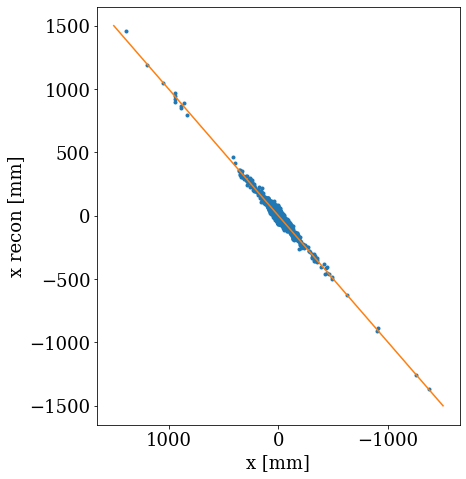

mu, sigma =  -4.66646664471196e-16 15.195181280583991


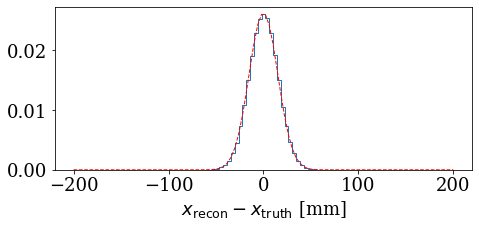

In [143]:

from scipy.stats import norm
import matplotlib.mlab as mlab

num = 0
denom = 0
for result in results:
    print(result)
    weight = 1/result['sigma']**2
    num = num+(df.query(q).eval(result['formula'])-result['b'])/result['m']*weight
    denom = denom+weight
    
x_recon = num/denom

fig, axs = plt.subplots(1,1,figsize=(7,7))
plt.plot(x[:], x_recon[:], marker='.', linestyle="")
xpt = pd.Series([-1500, 1500])
#plt.xlim(-.2,.2)
plt.plot(xpt, xpt, linestyle="-")
plt.gca().invert_xaxis()
plt.xlabel("x [mm]")
plt.ylabel("x recon [mm]")
plt.show()

residuals= x-x_recon
(mu, sigma) = norm.fit(residuals[abs(residuals)<150])
# the histogram of the data
n, bins, patches = plt.hist(residuals, bins=np.linspace(-200, 200, 100), 
                        histtype='step',density=True)
# add a 'best fit' line
y = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(bins-mu)**2/(2*sigma**2))
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel("$x_{\\rm recon}-x_{\\rm truth}$ [mm]")

print("mu, sigma = ", mu, sigma)

## now look at the total time resolution

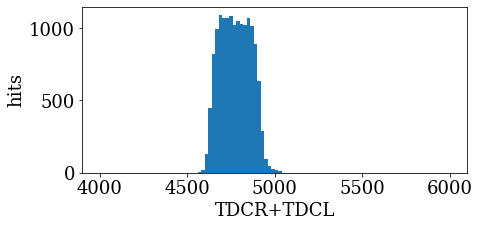

In [112]:
plt.hist(df.query(q).eval("TDCL+TDCR"), bins=100, range=(4000, 6000))
plt.xlabel("TDCR+TDCL")
plt.ylabel("hits")
plt.show()

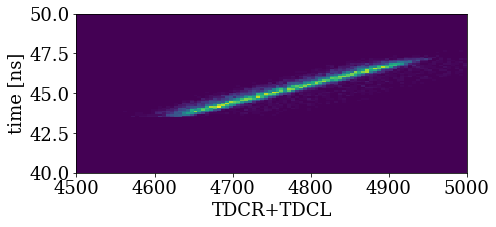

In [119]:
plt.hist2d(df.query(q).eval("TDCL+TDCR"), df.query(q).eval("avg_t"), 
           bins=100, range=((4500, 5000),(40, 50)))
plt.xlabel("TDCR+TDCL")
plt.ylabel("time [ns]")
plt.show()

In [152]:
min(df.component)

1.0